In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Producing Synthetic Data

In [ ]:
CMD = "wget https://raw.githubusercontent.com/Diyago/"\
  "GAN-for-tabular-data/master/requirements.txt"
!{CMD}
%pip install -r requirements.txt
%pip install tabgan

--2022-04-18 03:22:03--  https://raw.githubusercontent.com/Diyago/GAN-for-tabular-data/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197 [text/plain]
Saving to: ‘requirements.txt.2’

requirements.txt.2  100%[===================>]     197  --.-KB/s    in 0s      

2022-04-18 03:22:03 (7.82 MB/s) - ‘requirements.txt.2’ saved [197/197]



#### Loading Data for the local stores
We wish to generate data using tabgan.  To do so we must first load the csv of the local stores and will prep the data for generation.  To do so want to drop the columns that we will not be using for our models. At the current time of writing this we will not be including:

* Date - currently not needed will be subject to change if we wish to take in account the month has on a products sales
* Description - transformed to represent a numerical class
* CatergoryLvl2Desc
* CatergoryLvl3Desc
* description - weather is already described with conditions

In [ ]:
import pandas as pd

local_df = pd.read_csv('/content/drive/MyDrive/sprint2_local.csv')
local_df['Weekday'] = local_df['Weekday'].astype(bool)
local_df['Holiday'] = local_df['Holiday'].astype(bool)
local_df.shape

(9408, 18)

In [ ]:
# loading individual data values 
all_items = local_df['Description'].unique()
item_dfs = {}
for item in all_items:
    item_dfs[item] = local_df[local_df['Description'] == item].copy()
    item_dfs[item].drop(['StoreID', 'BusinessDate', 'Description', 'CategoryLvl2Desc', 'CategoryLvl3Desc'], axis=1, inplace=True)
    print(item, item_dfs[item].shape)

Caprese Sandwich (734, 13)
Breakfast Burrito Egg Beans & Rice (734, 13)
Everything Bagel (734, 13)
Blueberry Scone (734, 13)
Butter Croissant (734, 13)
Chocolate Croissant (734, 13)
Cinnamon Roll (734, 13)
Cookie - Chocolate Chunk (654, 13)
Egg| Spinach & Cheddar Sandwich on Ciabatta (734, 13)
Danish - Classic Cheese (734, 13)
Croissant - White Cheddar Jalapeno (734, 13)
Coffee Cake with Streusel (680, 13)
Almond Croissant (734, 13)


In [ ]:
from sklearn.model_selection import train_test_split

# split the data for Caprese Sandwich
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    item_dfs[all_items[0]].drop("SoldQuantity", axis=1),
    item_dfs[all_items[0]]["SoldQuantity"],
    test_size=0.20,
    #shuffle=False,
    random_state=42,
)

# Create dataframe versions for tabular GAN
df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)
df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

x_train[:, 6] = x_train[:, 6].astype(bool)
x_train[:, 6].dtype


dtype('O')

In [ ]:
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def synthetic_data(df_x_train, df_y_train, df_x_test):

    gen_x, gen_y = GANGenerator(gen_x_times=1.1, cat_cols=None,
            bot_filter_quantile=0.001, top_filter_quantile=0.999, \
                is_post_process=True,
            adversarial_model_params={
                "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
                "learning_rate": 0.02, "random_state": \
                    42, "n_estimators": 500,
            }, pregeneration_frac=2, only_generated_data=False,\
            gan_params = {"batch_size": 500, "patience": 25, \
            "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,\
            df_x_test, deep_copy=True, only_adversarial=False, \
            use_adversarial=True)
    return gen_x, gen_y

In [ ]:
syn_caprese_Sandwhich_x, gen_y = synthetic_data(df_x_train, df_y_train, df_x_test)

Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
def generate_synthetic(items, dataframes):
    syn_data_dict = dict()
    df_list = list()
    numpy_list = list()
    for item in items:
        df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
            dataframes[item].drop("SoldQuantity", axis=1),
            dataframes[item]["SoldQuantity"],
            test_size=0.20,
            #shuffle=False,
            random_state=42,
        )

        df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
            df_y_test.reset_index(drop=True)
        df_y_train = pd.DataFrame(df_y_train)
        df_y_test = pd.DataFrame(df_y_test)
        
        print(item)
        gen_x, gen_y = synthetic_data(df_x_train, df_y_train, df_x_test)
        
        syn_data_dict[item] = [gen_x, gen_y]

    return syn_data_dict



In [ ]:
syn_data = generate_synthetic(all_items, item_dfs)

Caprese Sandwich


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Breakfast Burrito Egg Beans & Rice


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Everything Bagel


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Blueberry Scone


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Butter Croissant


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Chocolate Croissant


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Cinnamon Roll


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Cookie - Chocolate Chunk


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Egg| Spinach & Cheddar Sandwich on Ciabatta


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Danish - Classic Cheese


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Croissant - White Cheddar Jalapeno


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Coffee Cake with Streusel


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

Almond Croissant


Fitting CTGAN transformers for each column:   0%|          | 0/12 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
syn_data

{'Almond Croissant': [      ReceivedQuantity  EndQuantity  LatestOrder  StockedOut  MissedSales  \
  0                    2            4           19           0     1.490512   
  1                    3            0           16           0     1.672095   
  2                    5            0           14           0     0.964382   
  3                    5            0           20           0     2.187281   
  4                    3            0           17           0     3.863229   
  ...                ...          ...          ...         ...          ...   
  1832                 4            0           12           1     1.044585   
  1833                 2            0           12           1     1.044585   
  1834                 8            0           12           1     1.609900   
  1835                 8            0           10           0     0.000000   
  1836                 6            0           10           0     0.000000   
  
        Holiday  Weekday     

## Find the optimial features

## Quick Linear Regression

###LR model for store 18


Store: 18
Product:  Caprese Sandwich
R2 score: -0.08483479018042273
MAE:  1.0679305439196476


ValueError: ignored

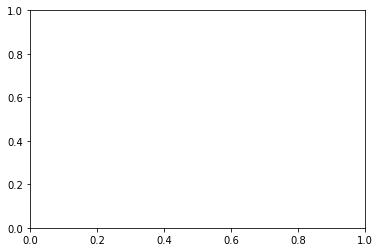

In [ ]:
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as sm
from sklearn import metrics
import csv

products = ['Caprese Sandwich','Breakfast Burrito Egg Beans & Rice','Everything Bagel','Blueberry Scone',
            'Butter Croissant','Chocolate Croissant','Cinnamon Roll','Cookie - Chocolate Chunk','Egg| Spinach & Cheddar Sandwich on Ciabatta',
            'Danish - Classic Cheese','Croissant - White Cheddar Jalapeno','Coffee Cake with Streusel','Almond Croissant']

for n in range(len(products)):

  data = local_df

  ### Split-out validation dataset
  array = data.values 
  m = array.shape[0]

  stop = 4691  ## 0~4690 is '18'
  count = 0
  temp1 = []
  s = products[n]
  for i in range(stop):
    if array[i,2] == s:
      temp1.append(array[i,:])
      count +=1

  data1 = np.array(temp1)

  ###### select the feature ######
  Y = np.array(data1[:,6], dtype=float)

  X1 = np.array( [data1[:,5].flatten(), data1[:,7].flatten(), data1[:,8].flatten(), data1[:,9].flatten(),
                data1[:,10].flatten(), data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/tempmax/tempmin/temp/condition
  X2 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/temp/condition
  X3 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  for i in range(X2.shape[0]):
    if X2[i,5] == 4:
      X2[i,5] = 3

  for i in range(X3.shape[0]):
    if X3[i,3] == 4:
      X3[i,3] = 3

  ############

  # Create Training and Test Split
  X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.2)
  #
  # Linear model
  LR = lm.LinearRegression().fit(X_train, Y_train)
  # Make predictions using the testing set
  Y_pred = LR.predict(X_test)
  
  print()
  print('Store: 18',)
  print('Product: ',products[n])
  print(f"R2 score: {sm.r2_score(Y_test, Y_pred)}")
  print("MAE: ",metrics.mean_absolute_error(Y_test, Y_pred))
  #print('coefficient:')
  #print(LR.coef_)

  #Loading future data
  data_F = pd.read_csv("/content/drive/MyDrive/store18_empty.csv", sep=',')

  ### Split-out dataset
  array_F = data_F.values 
  m_F = array_F.shape[0]

  X_F = np.array( [array_F[:,11].flatten(), array_F[:,12].flatten(), array_F[:,15].flatten(), array_F[:,16].flatten()] ).T

  for i in range(X_F.shape[0]):
    condition = X_F[i,-1]
    if condition == 'Clear':
      X_F[i,-1] = 1
    if condition == 'Partially cloudy':
      X_F[i,-1] = 2
    if condition[:4] == 'Rain':
      X_F[i,-1] = 3
    if condition == 'Overcast':
      X_F[i,-1] = 5

  #make prediction
  YF_pred = LR.predict(X_F)
  for i in range(YF_pred.shape[0]):
    YF_pred[i] = round(YF_pred[i])
  
  print('Predict future sales(2020-6-30 - 2021-6-29):')
  print(YF_pred)


###LR model for store 117

In [ ]:
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as sm
from sklearn import metrics
import csv

products = ['Caprese Sandwich','Breakfast Burrito Egg Beans & Rice','Everything Bagel','Blueberry Scone',
            'Butter Croissant','Chocolate Croissant','Cinnamon Roll','Cookie - Chocolate Chunk','Egg| Spinach & Cheddar Sandwich on Ciabatta',
            'Danish - Classic Cheese','Croissant - White Cheddar Jalapeno','Coffee Cake with Streusel','Almond Croissant']

for n in range(len(products)):

  data = local_df

  ### Split-out validation dataset
  array = data.values 
  m = array.shape[0]

  stop = 4715  ## 4691~9405 is '117'
  count = 0
  temp1 = []
  s = products[n]
  for i in range(stop):
    if array[i+4691,2] == s:
      temp1.append(array[i,:])
      count +=1

  data1 = np.array(temp1)

  ###### select the feature ######
  Y = np.array(data1[:,6], dtype=float)

  X1 = np.array( [data1[:,5].flatten(), data1[:,7].flatten(), data1[:,8].flatten(), data1[:,9].flatten(),
                data1[:,10].flatten(), data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/tempmax/tempmin/temp/condition
  X2 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/temp/condition
  X3 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  for i in range(X2.shape[0]):
    if X2[i,5] == 4:
      X2[i,5] = 3

  for i in range(X3.shape[0]):
    if X3[i,3] == 4:
      X3[i,3] = 3

  ############

  # Create Training and Test Split
  X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.2)
  #
  # Linear model
  LR = lm.LinearRegression().fit(X_train, Y_train)
  # Make predictions using the testing set
  Y_pred = LR.predict(X_test)
  
  print()
  print('Store: 117',)
  print('Product: ',products[n])
  print(f"R2 score: {sm.r2_score(Y_test, Y_pred)}")
  print("MAE: ",metrics.mean_absolute_error(Y_test, Y_pred))
  #print('coefficient:')
  #print(LR.coef_)


  #Loading future data
  data_F = pd.read_csv("/content/drive/MyDrive/store117_empty.csv", sep=',')

  ### Split-out dataset
  array_F = data_F.values 
  m_F = array_F.shape[0]

  X_F = np.array( [array_F[:,11].flatten(), array_F[:,12].flatten(), array_F[:,15].flatten(), array_F[:,16].flatten()] ).T

  for i in range(X_F.shape[0]):
    condition = X_F[i,-1]
    if condition == 'Clear':
      X_F[i,-1] = 1
    if condition == 'Partially cloudy':
      X_F[i,-1] = 2
    if condition[:4] == 'Rain':
      X_F[i,-1] = 3
    if condition == 'Overcast':
      X_F[i,-1] = 5

  #make prediction
  YF_pred = LR.predict(X_F)
  for i in range(YF_pred.shape[0]):
    YF_pred[i] = round(YF_pred[i])
  
  print('Predict future sales(2020-6-30 - 2021-6-29):')
  print(YF_pred)


Store: 117
Product:  Caprese Sandwich
R2 score: 0.027925311433184663
MAE:  2.0595838953898915
Predict future sales(2020-6-30 - 2021-6-29):
[3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 4. 3. 4. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 3. 3. 4. 3.
 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 4. 3. 3. 4. 3. 3. 4. 4. 3. 3. 3. 3. 3.
 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 4. 4.
 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 4. 3. 3. 4. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.

###LR model for store 332

In [ ]:
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as sm
from sklearn import metrics
import csv

products = ['Caprese Sandwich','Breakfast Burrito Egg Beans & Rice','Everything Bagel','Blueberry Scone',
            'Butter Croissant','Chocolate Croissant','Cinnamon Roll','Cookie - Chocolate Chunk','Egg| Spinach & Cheddar Sandwich on Ciabatta',
            'Danish - Classic Cheese','Croissant - White Cheddar Jalapeno','Coffee Cake with Streusel','Almond Croissant']

for n in range(len(products)):

  data = local_df

  ### Split-out validation dataset
  array = data.values 
  m = array.shape[0]

  stop = 4717  ## 9406~14122 is '332'
  count = 0
  temp1 = []
  s = products[n]
  for i in range(stop):
    if array[i+9406,2] == s:
      temp1.append(array[i,:])
      count +=1

  data1 = np.array(temp1)

  ###### select the feature ######
  Y = np.array(data1[:,6], dtype=float)

  X1 = np.array( [data1[:,5].flatten(), data1[:,7].flatten(), data1[:,8].flatten(), data1[:,9].flatten(),
                data1[:,10].flatten(), data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/tempmax/tempmin/temp/condition
  X2 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,13].flatten(),
                data1[:,14].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  #holiday/weekday/temp/condition
  X3 = np.array( [data1[:,11].flatten(), data1[:,12].flatten(), data1[:,15].flatten(), data1[:,16].flatten()] , dtype=float).T

  for i in range(X2.shape[0]):
    if X2[i,5] == 4:
      X2[i,5] = 3

  for i in range(X3.shape[0]):
    if X3[i,3] == 4:
      X3[i,3] = 3

  ############

  # Create Training and Test Split
  X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.2)
  #
  # Linear model
  LR = lm.LinearRegression().fit(X_train, Y_train)
  # Make predictions using the testing set
  Y_pred = LR.predict(X_test)
  
  print()
  print('Store: 332',)
  print('Product: ',products[n])
  print(f"R2 score: {sm.r2_score(Y_test, Y_pred)}")
  print("MAE: ",metrics.mean_absolute_error(Y_test, Y_pred))
  #print('coefficient:')
  #print(LR.coef_)


  #Loading future data
  data_F = pd.read_csv("/content/drive/MyDrive/store332_empty.csv", sep=',')

  ### Split-out dataset
  array_F = data_F.values 
  m_F = array_F.shape[0]

  X_F = np.array( [array_F[:,11].flatten(), array_F[:,12].flatten(), array_F[:,15].flatten(), array_F[:,16].flatten()] ).T

  for i in range(X_F.shape[0]):
    condition = X_F[i,-1]
    if condition == 'Clear':
      X_F[i,-1] = 1
    if condition == 'Partially cloudy':
      X_F[i,-1] = 2
    if condition[:4] == 'Rain':
      X_F[i,-1] = 3
    if condition == 'Overcast':
      X_F[i,-1] = 5

  #make prediction
  YF_pred = LR.predict(X_F)
  for i in range(YF_pred.shape[0]):
    YF_pred[i] = round(YF_pred[i])
  
  print('Predict future sales(2020-6-30 - 2021-6-29):')
  print(YF_pred)


Store: 332
Product:  Caprese Sandwich
R2 score: -0.06163560456788253
MAE:  2.209645566379493
Predict future sales(2020-6-30 - 2021-6-29):
[3. 3. 3. 4. 3. 4. 4. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4.
 4. 4. 4. 3. 3. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 4.
 4. 3. 4. 3. 4. 4. 4. 4. 4. 4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 4. 4. 4. 4.
 4. 4. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 2. 3. 3. 4.
 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 3. 4. 4. 4. 3. 3. 4.
 4. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 4. 3.
 4. 4. 3. 4. 4. 4. 4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 4. 4. 3. 3. 3. 3. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 3. 3. 4. 4.
 3. 3. 3. 3. 4. 4. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 3. 4. 4. 4. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 3. 4. 3.
 4. 4. 3. 4. 3. 3. 4. 4. 3. 3. 4. 4. 3. 3. 3. 3. 3. 4. 3. 

## Comparing the four different kind of models



## Functions

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [ ]:
import seaborn as sns

def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'../model_output/{model_name}_forecast.png')

#### Random Forest

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from numpy import random
from matplotlib import cm
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
from pandas.tseries.holiday import USFederalHolidayCalendar

future_blank_df = pd.DataFrame(columns = local_df.columns)
start_date = datetime(2020, 6, 30) 
print(start_date)

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018-01-01', end='2022-12-31').to_pydatetime()
for i in range(0, 365):
    date = start_date + timedelta(days=i) 
    holiday = 0
    weekday = 1
    if(date.weekday() == 5 or date.weekday() == 6):
        weekday = 0
    if(date in holidays):
        holiday = 1
    
    
    future_blank_df = future_blank_df.append({'BusinessDate': str(date).split(" ")[0], 'Holiday': holiday, 'Weekday': weekday}, ignore_index=True)

future_blank_df.to_csv('blank_future_data.csv')

capreseSandwichData =  local_df.loc[local_df['Description'] == 'Caprese Sandwich'] 
#select the holiday, weekend and temperature features we will be testing on
features = local_df.columns[11:17]
#get the dataframe data from those columns
x = capreseSandwichData[features]
#get the sold qualitys
y = capreseSandwichData.SoldQuantity

#seperate the features and target datas in half so we can train on them
X_train = x[:int(len(capreseSandwichData) * .8)]
X_test = x[int(len(capreseSandwichData) * .2):]
Y_train = y[:int(len(capreseSandwichData) * .8)]
Y_test = y[int(len(capreseSandwichData) * .2):]

X_full = x
Y_full = y

2020-06-30 00:00:00


Optimal Training Values
Score:  0.7857142857142857
N Estimator:  62
Depth:  19


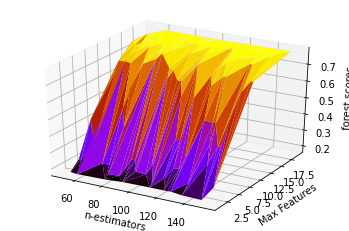

In [ ]:
n_estimators = []
forest_scores = []
max_depths = []
i = 0
for i in range(50,155):
    depth = random.randint(1,20)
    forest_test = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=0).fit(X_train, Y_train)
    forest_score = forest_test.score(X_test, Y_test)
    n_estimators.append(i)
    forest_scores.append(forest_score)
    max_depths.append(depth)
    
ax = plt.figure().add_subplot(projection='3d')

max_value = max(forest_scores) 
max_index = forest_scores.index(max_value)
print("Optimal Training Values")
print("Score: ", forest_scores[max_index])
print("N Estimator: ", n_estimators[max_index])
print("Depth: ", max_depths[max_index])

ax.plot_trisurf(n_estimators,max_depths,forest_scores, linewidth=.5, cmap=cm.gnuplot)
ax.set_xlabel('n-estimators')
ax.set_zlabel('forest scores')
ax.set_ylabel('Max Features')

plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

products = local_df['Description'].unique()
scores = {}
min_product = ''
max_product = ''
min_score = 100
max_score = 0

for product in products:
    productData =  local_df.loc[local_df['Description'] == product] 

    #select the holiday, weekend and temperature features we will be testing on
    features = ['Holiday', 'Weekday','tempmin','tempmax', 'temp',  'conditions']

    #get the dataframe data from those columns
    x = productData[features]

    #get the sold qualitys
    y = productData.SoldQuantity

    #seperate the features and target datas in half so we can train on them
    X_train = x[:int(len(productData) * .8)]
    X_test = x[int(len(productData) * .2):]
    Y_train = y[:int(len(productData) * .8)]
    Y_test = y[int(len(productData) * .2):]

    X_full = x
    Y_full = y
    forest_test = RandomForestClassifier(n_estimators=70, max_depth =19 ,max_features=6, random_state=13).fit(X_train, Y_train)
    forest_score = forest_test.score(X_test, Y_test)
    scores[product] = forest_score
    if forest_score < min_score: 
        min_score = forest_score
        min_product = product
    if forest_score > max_score: 
        max_score = forest_score
        max_product = product


    y_pred = forest_test.predict(X_test)
    y_actual = Y_test.tolist()
    i = 0
    true_positive_rate = 0.0
    true_negative_rate = 0.0
    for y in y_pred:
        if(y == y_actual[i]):
            true_positive_rate += 1
        else:
            true_negative_rate += 1
        i+=1
        

    
    total = true_positive_rate + true_negative_rate

    true_positive_rate = true_positive_rate/total * 100
    true_negative_rate = true_negative_rate/total * 100

    print("Metrics for product ", product)
    print("Accuracy:", forest_score)
    print("True Positive Rate:", true_positive_rate)
    print("True Negative Rate:", true_negative_rate)
    print("F1-Score: ", f1_score(y_actual, y_pred, average='macro'))
    print("Confusion Matrix")
    print(confusion_matrix(y_actual, y_pred))



values = scores.values()
print(" {} this is the product with the least score of {} and this product :\
      {} has the greatest score of {}".format(min_product,min_score,max_product,max_score))
print("this is the average score {}".format(sum(values)/len(values)))

Metrics for product  Caprese Sandwich
Accuracy: 0.7755102040816326
True Positive Rate: 77.55102040816327
True Negative Rate: 22.448979591836736
F1-Score:  0.8159967904743763
Confusion Matrix
[[69  1  4  0  0  0  0  0  0  0  0  0  0]
 [ 2 75  9  2  0  0  1  0  0  0  0  0  1]
 [ 4  4 77  1  2  1  1  0  2  0  0  0  0]
 [11  4  4 51  1  1  4  2  0  0  1  0  0]
 [ 1  4  7  3 37  1  3  0  1  1  0  0  0]
 [ 4  1  9  3  0 36  0  1  0  1  0  0  0]
 [ 2  2  5  3  1  1 42  0  0  0  0  0  0]
 [ 2  0  2  1  0  0  0 24  0  0  0  0  0]
 [ 4  0  2  1  0  1  0  0 17  1  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3]]
Metrics for product  Breakfast Burrito Egg Beans & Rice
Accuracy: 0.7619047619047619
True Positive Rate: 76.19047619047619
True Negative Rate: 23.809523809523807
F1-Score:  0.46979070629786635
Confusion Matrix
[[ 79   3   0   0   1   1   0   0   0   0   0]
 [  2

In [ ]:
#creating the model with those optimal values
locations = ["332", "117", "18"]


for location in locations:
    forest_test = RandomForestClassifier(n_estimators=70, max_depth=19, random_state=0).fit(X_full, Y_full)
    future_blank_df = pd.DataFrame(columns = local_df.columns)
    default_table = pd.read_csv('/content/drive/MyDrive/store' + location + '_empty.csv')
    days = default_table['BusinessDate'].unique()
    features = default_table.columns[11:17]
    x = capreseSandwichData[features]
    y_pred = forest_test.predict(x)
    i = 0
    df_columns = local_df.columns 

    caprese_future_df = pd.DataFrame(columns = df_columns)

    for day in days:
        caprese_future_df = caprese_future_df.append({'BusinessDate': default_table[(default_table['BusinessDate'] == day)].BusinessDate.item(), 'Holiday': default_table[(default_table['BusinessDate'] == day)].Holiday.item(), 'Weekday': default_table[(default_table['BusinessDate'] == day)].Weekday.item(), 'PredictedSales': y_pred[i] }, ignore_index=True)
        i+=1
    new_file_name = 'caprese_future_data_random_forest_' + location + '.csv'
    caprese_future_df.to_csv(new_file_name)

#### Gradient Boosting Machine

Optimal Training Values
Score:  0.5732122587968218
N Estimator:  94
Depth:  19


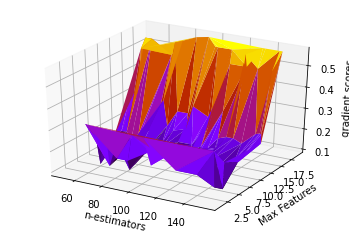

In [ ]:
#figuring out optimal data values
n_estimators = []
gradient_scores = []
max_depths = []
i = 0
for i in range(50,155):
    depth = random.randint(1,20)
    
    gradientBoost = GradientBoostingClassifier(n_estimators=i, learning_rate=.2, max_depth=depth, random_state=0).fit(X_train, Y_train)
    gradient_score = gradientBoost.score(X_test, Y_test)
    n_estimators.append(i)
    gradient_scores.append(gradient_score)
    max_depths.append(depth)
    
ax = plt.figure().add_subplot(projection='3d')

max_value = max(gradient_scores) 
max_index = gradient_scores.index(max_value)
print("Optimal Training Values")
print("Score: ", gradient_scores[max_index])
print("N Estimator: ", n_estimators[max_index])
print("Depth: ", max_depths[max_index])

ax.plot_trisurf(n_estimators,max_depths,gradient_scores, linewidth=.5, cmap=cm.gnuplot)
ax.set_xlabel('n-estimators')
ax.set_zlabel('gradient scores')
ax.set_ylabel('Max Features')

plt.show()


In [ ]:
products = local_df['Description'].unique()
scores = {}
min_product = ''
max_product = ''
min_score = 100
max_score = 0

gradient_scores = []
for product in products:
    productData =  local_df.loc[local_df['Description'] == product] 

    #select the holiday, weekend and temperature features we will be testing on
    features = ['Holiday', 'Weekday','tempmin','tempmax', 'temp',  'conditions']

    #get the dataframe data from those columns
    x = productData[features]

    #get the sold qualitys
    y = productData.SoldQuantity

    #seperate the features and target datas in half so we can train on them
    X_train = x[:int(len(productData) * .8)]
    X_test = x[int(len(productData) * .2):]
    Y_train = y[:int(len(productData) * .8)]
    Y_test = y[int(len(productData) * .2):]

    X_full = x
    Y_full = y
    
    gradientBoost = GradientBoostingClassifier(n_estimators=55, learning_rate=.2, max_depth=19, random_state=0).fit(X_train, Y_train)
    gradient_score = gradientBoost.score(X_test, Y_test)
    gradient_scores.append(gradient_score)
    scores[product] = gradient_score
    if gradient_score < min_score: 
        min_score = gradient_score
        min_product = product
    if gradient_score > max_score: 
        max_score = gradient_score
        max_product = product
        y_pred = forest_test.predict(X_test)
    y_actual = Y_test.tolist()
    i = 0
    true_positive_rate = 0.0
    true_negative_rate = 0.0
    for y in y_pred:
        try:
          if(y == y_actual[i]):
              true_positive_rate += 1
          else:
              true_negative_rate += 1
          i+=1
        except:
          continue

    
    total = true_positive_rate + true_negative_rate

    true_positive_rate = true_positive_rate/total * 100
    true_negative_rate = true_negative_rate/total * 100
    print("Metrics for product ", product)
    print("Accuracy:", gradient_score)
    print("True Positive Rate:", true_positive_rate)
    print("True Negative Rate:", true_negative_rate)
    print("F1-Score: ", f1_score(y_actual, y_pred, average='macro'))
    print("Confusion Matrix")
    print(confusion_matrix(y_actual, y_pred))
values = scores.values()
print(" {} this is the product with the least score of {} and this product :\
      {} has the greatest score of {}".format(min_product,min_score,max_product,max_score))
print("this is the average score {}".format(sum(values)/len(values)))

    

Metrics for product  Caprese Sandwich
Accuracy: 0.7806122448979592
True Positive Rate: 13.435374149659864
True Negative Rate: 86.56462585034014
F1-Score:  0.12105613617850516
Confusion Matrix
[[ 6 10 13  9 14  5  9  3  4  1  0  0  0]
 [ 1 12 16 11 18 11 11  4  4  1  1  0  0]
 [ 0  6 10 12 15 19 22  2  5  1  0  0  0]
 [ 0  4  7 12 11 15 18  3  6  3  0  0  0]
 [ 1  2  6  7 10  7  7  6  8  2  2  0  0]
 [ 0  1  0  3  8 12 12  6  5  5  2  1  0]
 [ 1  0  1  2  9  6  5  7 17  4  2  2  0]
 [ 0  0  0  1  5  5  3  3  9  1  1  0  1]
 [ 0  0  2  3  3  5  3  2  6  0  2  0  0]
 [ 0  0  0  0  0  3  3  4  4  2  1  0  0]
 [ 0  0  0  1  0  0  2  2  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1  1  0  1  0]]
Metrics for product  Breakfast Burrito Egg Beans & Rice
Accuracy: 0.7619047619047619
True Positive Rate: 8.503401360544217
True Negative Rate: 91.49659863945578
F1-Score:  0.05568530754120092
Confusion Matrix
[[ 3 11 11 17 12  6 11  4  3  4  2  0  0]
 [ 2  7 19

ValueError: ignored

In [ ]:
#creating the model with those optimal values
locations = ["332", "117", "18"]


for location in locations:
    gradientBoost = GradientBoostingClassifier(n_estimators=150, learning_rate=.2, max_depth=6, random_state=0).fit(X_full, Y_full)
    future_blank_df = pd.DataFrame(columns = local_df.columns)
    default_table = pd.read_csv('/content/drive/MyDrive/store' + location + '_empty.csv')
    days = default_table['BusinessDate'].unique()
    features = default_table.columns[11:17]
    x = capreseSandwichData[features]
    y_pred = gradientBoost.predict(x)
    i = 0
    df_columns = local_df.columns
    caprese_future_df = pd.DataFrame(columns = df_columns)

    for day in days:
        caprese_future_df = caprese_future_df.append({'BusinessDate': default_table[(default_table['BusinessDate'] == day)].BusinessDate.item(), 'Holiday': default_table[(default_table['BusinessDate'] == day)].Holiday.item(), 'Weekday': default_table[(default_table['BusinessDate'] == day)].Weekday.item(), 'PredictedSales': y_pred[i], 'StoreID': '332' }, ignore_index=True)
        i+=1
    new_file_name = 'caprese_future_data_gradient_boost_' + location + '.csv'
    caprese_future_df.to_csv(new_file_name)

#### Light GBM

#### XGBoost

In [ ]:
def getModel(name):
    #get the values for the specific name
    ProductData =  local_df.loc[local_df['Description'] == name] 
    #select the holiday, weekend and temperature features we will be testing on
    features = local_df.columns[11:17]
    #get the dataframe data from those columns
    x = ProductData[features]
    #get the sold qualitys
    y = ProductData.SoldQuantity

    #seperate the features and target datas in half so we can train on them
    X_train = x[:int(len(ProductData) * .8)]
    X_test = x[int(len(ProductData) * .2):]
    Y_train = y[:int(len(ProductData) * .8)]
    Y_test = y[int(len(ProductData) * .2):]

    X_full = x
    Y_full = y
    
    return X_train, Y_train, X_test, Y_test


In [ ]:
import xgboost as xg
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def classify(xTrain, yTrain, xTest, yTest):
    XGBBoost = xg.XGBClassifier().fit(xTrain, yTrain)

    y_pred = XGBBoost.predict(xTest)
    y_actual = yTest.tolist()
    i = 0
    true_positive_rate = 0.0
    true_negative_rate = 0.0
    for y in y_pred:

        if(y == y_actual[i]):
            true_positive_rate += 1
        else:
            true_negative_rate += 1
        i+=1



    total = true_positive_rate + true_negative_rate
    true_positive_rate = true_positive_rate/total * 100
    true_negative_rate = true_negative_rate/total * 100

    print("True Positive Rate: ", true_positive_rate, "%")
    print("True Negative Rate: ", true_negative_rate, "%")
    print("F1-Score: ", f1_score(y_actual, y_pred, average='macro'))
    print("Confusion Matrix")
    print(confusion_matrix(y_actual, y_pred))

    return XGBBoost


In [ ]:
X_train, Y_train, X_test, Y_test = getModel('Caprese Sandwich')
XGB = classify(X_train, Y_train, X_test, Y_test)

True Poisitive Rate:  43.24631101021566 %
True Negative Rate:  56.75368898978434 %
F1-Score:  0.3081359137388639
Confusion Matrix
[[101  55  11   1   0   0   2   0   0   0   0   0   0]
 [ 24 175  19   1   0   0   0   1   0   0   0   0   0]
 [ 30  58  70   0   0   0   1   0   0   1   0   0   0]
 [ 22  47   7   4   1   0   0   1   0   0   0   0   0]
 [ 12  24  18   1   1   0   0   0   0   0   0   0   0]
 [ 10  23  14   0   0   6   0   0   0   0   0   0   0]
 [ 11  24  13   0   0   0   8   0   0   0   0   0   0]
 [  7  10   2   0   0   0   0  10   0   0   0   0   0]
 [  3  11   9   1   0   1   0   1   0   0   0   0   0]
 [  2   6   7   0   0   0   0   0   0   2   0   0   0]
 [  0   2   1   1   0   0   0   0   0   0   2   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   2   0]
 [  2   1   0   0   0   0   0   0   0   0   0   0   0]]


,Holiday,Weekday,temp,tempmin,tempmax,conditions
0,False,False,71.3,59.6,83.3,1
13,False,False,73.0,62.8,82.5,1
26,False,True,72.6,63.8,81.5,1
39,False,True,71.1,64.1,79.6,1
51,False,True,69.8,64.6,76.9,2
...,...,...,...,...,...,...
11239,False,False,71.5,55.3,90.6,1
11252,False,True,73.3,61.2,93.5,1
11265,False,True,67.5,60.2,83.0,3
11278,False,True,58.5,55.9,62.3,3


In [ ]:
# this will be an experiment to test synthetic data on the XGBoost Model
X_syn = syn_data['Caprese Sandwich'][0]
#X_syn.drop(['ReceivedQuantity', 'EndQuantity', 'LatestOrder', 'StockedOut', 'MissedSales'], axis=1, inplace=True)
X_syn

,Holiday,Weekday,temp,tempmin,tempmax,conditions
0,True,True,68.222304,68.737778,77.414844,1
1,True,True,54.287247,64.324897,92.690919,1
2,True,True,60.313611,71.623390,87.257224,2
3,True,True,62.734738,63.296987,76.504295,2
4,True,True,53.030329,64.332583,78.295376,1
...,...,...,...,...,...,...
1551,False,True,78.300000,70.700000,88.200000,1
1552,False,False,76.700000,67.500000,87.100000,1
1553,False,False,76.200000,68.700000,86.100000,1
1554,False,True,78.900000,69.600000,89.700000,1


In [ ]:
X_train

,Holiday,Weekday,temp,tempmin,tempmax,conditions
0,False,False,71.3,59.6,83.3,1
13,False,False,73.0,62.8,82.5,1
26,False,True,72.6,63.8,81.5,1
39,False,True,71.1,64.1,79.6,1
51,False,True,69.8,64.6,76.9,2
...,...,...,...,...,...,...
11239,False,False,71.5,55.3,90.6,1
11252,False,True,73.3,61.2,93.5,1
11265,False,True,67.5,60.2,83.0,3
11278,False,True,58.5,55.9,62.3,3


In [ ]:
new_train = pd.concat([X_train, X_syn], ignore_index=True)
new_train

,Holiday,Weekday,temp,tempmin,tempmax,conditions
0,False,False,71.3,59.6,83.3,1
1,False,False,73.0,62.8,82.5,1
2,False,True,72.6,63.8,81.5,1
3,False,True,71.1,64.1,79.6,1
4,False,True,69.8,64.6,76.9,2
...,...,...,...,...,...,...
2431,False,True,78.3,70.7,88.2,1
2432,False,False,76.7,67.5,87.1,1
2433,False,False,76.2,68.7,86.1,1
2434,False,True,78.9,69.6,89.7,1


In [ ]:
y_syn = syn_data['Caprese Sandwich'][1]
y_syn.dtype

dtype('int64')

In [ ]:
type(y_syn)

pandas.core.series.Series

In [ ]:
new_y = pd.concat([Y_train, y_syn], ignore_index=True)
new_y

0       1
1       0
2       2
3       4
4       2
       ..
2431    1
2432    1
2433    1
2434    9
2435    5
Name: SoldQuantity, Length: 2436, dtype: int64

In [ ]:
syn_XGB = classify(new_train, new_y, X_test, Y_test)

True Poisitive Rate:  41.43019296254257 %
True Negative Rate:  58.56980703745743 %
F1-Score:  0.2781227941107542
Confusion Matrix
[[ 99  51  19   1   0   0   0   0   0   0   0   0   0]
 [ 40 152  27   0   1   0   0   0   0   0   0   0   0]
 [ 26  52  82   0   0   0   0   0   0   0   0   0   0]
 [ 25  41   7   7   1   0   0   1   0   0   0   0   0]
 [ 10  23  15   2   6   0   0   0   0   0   0   0   0]
 [ 14  20  14   0   0   5   0   0   0   0   0   0   0]
 [ 17  23  11   1   0   1   3   0   0   0   0   0   0]
 [ 10   7   7   1   0   0   0   4   0   0   0   0   0]
 [  6   8   9   0   0   0   0   1   2   0   0   0   0]
 [  4   5   6   0   0   0   0   0   0   2   0   0   0]
 [  0   3   1   0   0   0   0   0   0   0   2   0   0]
 [  0   2   1   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0   0   0   1]]


In [ ]:
all_syn_XGB = classify(X_syn, y_syn, X_test, Y_test)

True Poisitive Rate:  38.592508513053346 %
True Negative Rate:  61.407491486946654 %
F1-Score:  0.206855751445013
Confusion Matrix
[[105  41  24   0   0   0   0   0   0   0   0   0   0]
 [ 52 134  30   2   0   0   0   1   0   1   0   0   0]
 [ 38  51  70   0   0   0   0   1   0   0   0   0   0]
 [ 30  30  13   8   1   0   0   0   0   0   0   0   0]
 [ 10  17  20   1   8   0   0   0   0   0   0   0   0]
 [ 14  19  13   0   1   5   0   0   1   0   0   0   0]
 [ 17  22  13   1   0   1   1   0   1   0   0   0   0]
 [ 10   5   8   2   1   0   0   3   0   0   0   0   0]
 [  5  10   5   0   0   0   0   1   5   0   0   0   0]
 [  9   2   6   0   0   0   0   0   0   0   0   0   0]
 [  1   1   3   0   0   0   0   0   0   0   1   0   0]
 [  0   2   1   0   0   0   0   0   0   0   0   0   0]
 [  1   1   1   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
import matplotlib.pyplot as plt

xg.plot_importance(XGB)
plt.rcParams['figure.figsize'] = [5,5]
plt.show()

# ? print(rmse)

NameError: ignored

#### LSTM 

In [ ]:
# leaving this for future work possibly 

from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

def lstm_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    get_scores(predictions, y_test, 'LSTM')
    
    plot_results(predictions, local_df, 'LSTM')
